# Brief 14 - Classification d'images  
Ressource:
* https://kapernikov.com/tutorial-image-classification-with-scikit-learn/

## 1 - Données:  
Les données proviennent du Dataset:
    ​ https://vcla.stat.ucla.edu/people/zhangzhang-si/HiT/AnimalFace.zip


## 2 - Fonctions de manipulation d'images.
* lecture
* redimensionner les images
* stocker les données dans un dictionnaire contenant les images, les étiquettes (animal), les noms de fichiers originaux et une description.
  
Les images elles-mêmes seront stockées sous forme de tableaux numpy contenant leurs valeurs RVB. Le dictionnaire sera enregistré dans un fichier pickle à l'aide de la librairie joblib. La structure des données sera basée sur celle utilisée pour les ensembles de données de test dans scikit-learn.

In [35]:
import numpy as np
import pandas as pds

import joblib

from skimage.io import imread
from skimage.feature import hog
from skimage.transform import rescale, resize
from skimage import data, color

import matplotlib.pyplot as plt

import os 

from collections import Counter
 
#----------------------------------- Variables globales ----------------------------------------------
#data = dict()
#data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
#data['label'] = []
#data['filename'] = []
#data['data'] = []

d_DATA={'description': [],'label': [], 'filename': [],'data': []}
LARGEUR= 80
HAUTEUR= LARGEUR

### Note:  
Un f-string convertit automatiquement les échappements avec des backslashs comme par exemple : \n , \", \t, etc. Donc si on ne veut pas que python interprète ces échappements il faut utiliser les raw string en ecrivant r avant la chaine de caractères et si on veut utiliser des raw f-strings il faut mettre fr.

In [37]:
# modify to fit your system 
# les f strings: 
#  Un string convertit automatiquement les échappements avec des backslashs comme par exemple : \n , \", \t,...
#  si on utilise une "raw string" python n'interprète ces échappements.

data_path = fr'{os.getenv("HOME")}/Documents/brief/brief14-Classification_Images/data/AnimalFace/Image'
l_rep= os.listdir(data_path) # Liste contenant le nom de tout les sous répertoires qui contiennent les images

#l_rep

### Prise en main de la fonction resize

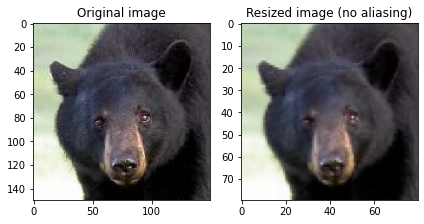

In [38]:
img = imread(os.path.join("/home/jpphi/Documents/brief/brief14-Classification_Images/data/AnimalFace/Image/BearHead",\
                            "bearfrontal0001.jpg"))

img_resized = resize(img, (LARGEUR, HAUTEUR), anti_aliasing=True)

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(img, cmap='BrBG')
axes[0].set_title("Original image")

axes[1].imshow(img_resized, cmap='BrBG')
axes[1].set_title("Resized image (no aliasing)")

#axes[0].set_xlim(0, 512)
#axes[0].set_ylim(512, 0)
plt.tight_layout()
plt.show()

### Redimentionnement du jeux d'image  
**Attention au temps d'exécution!**

In [55]:
d_DATA["description"] = f'resized ({LARGEUR}x{HAUTEUR}) animal images in rgb'
for el in l_rep:
    repertoire= fr"{data_path}/{el}/"
    for file in os.listdir(repertoire):
        #print(file)
        if file[-3:] in {'jpg', 'png'}: # "file" est il du type jpg ou png? sinon on l'ignore
            img = imread(os.path.join(repertoire, file))
            img = resize(img, (LARGEUR, HAUTEUR)) #[:,:,::-1]
            d_DATA['label'].append(el[:-4]) # Le :-4 Permet d'enlever "Head" du nom du fichier et de ne concerver que le nom de l'animal
            d_DATA['filename'].append(file)
            d_DATA['data'].append(img)

joblib.dump(d_DATA, f"animal_faces_{LARGEUR}x{HAUTEUR}px.pkl")


['animal_faces_80x80px.pkl']

## 3 - Créer le jeu de données en vous servant de votre fonction précédemment créée.  
Il y a pas mal d'animaux inclus dans le jeu de données, sélectionnez 8 classes d’animaux de votre choix. Nous définissons la largeur (et la hauteur) à 80 pixels.  
  
**À partir d'ici nous n'utiliseront plus le dictionnaire d_DATA global**  
**Attention au temps de chargement**


In [100]:
data = joblib.load("data/animal_faces_80x80px.pkl")

# Problème de "Natural" libellé "Nat" à cause du "[:-4]" dans d_DATA['label'].append(el[:-4])
for i,el in enumerate(data["label"]):
    if el== "Nat":
        data["label"][i]= "Natural"


## 4 - Analysez le nouveau jeu de données fraîchement créé.  
(nombre d’échantillons, les éléments “clés” des données, taille des images, labels des images).


In [99]:
print("Nombre d'échantillon: ", len(data['data']))
print('Clefs du dictionnaire: ', list(data.keys()))
print('description: ', data['description'])
print('Taille des images: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))

Counter(data['label'])

Nombre d'échantillon:  4671
Clefs du dictionnaire:  ['description', 'label', 'filename', 'data']
description:  resized (80x80) animal images in rgb
Taille des images:  (80, 80, 3)
labels: ['Bear' 'Cat' 'Chicken' 'Cow' 'Deer' 'Dog' 'Duck' 'Eagle' 'Elephant'
 'Human' 'Lion' 'Monkey' 'Mouse' 'Natural' 'Panda' 'Pig' 'Pigeon' 'Rabbit'
 'Sheep' 'Tiger' 'Wolf']


Counter({'Pig': 409,
         'Bear': 404,
         'Wolf': 400,
         'Natural': 32,
         'Rabbit': 400,
         'Chicken': 400,
         'Panda': 468,
         'Human': 400,
         'Pigeon': 392,
         'Eagle': 343,
         'Cat': 477,
         'Tiger': 294,
         'Sheep': 200,
         'Elephant': 200,
         'Deer': 119,
         'Mouse': 100,
         'Monkey': 100,
         'Dog': 389,
         'Cow': 101,
         'Duck': 102,
         'Lion': 97})

## 5 - Affichez un exemple de chaque animal inclus dans le jeu de données :
* Utilisez “np.unique” pour obtenir toutes les valeurs uniques dans la liste des étiquettes.
* Configurer la figure et les axes matplotlib, en fonction du nombre d'étiquettes.
* Faire un tracé pour chaque type d'étiquette. La méthode index renvoie l'index du premier élément correspondant à sa chaîne de recherche, label dans notre cas Nous pourrions par exemple afficher ceci :

    ![Image](img1.png)  
    
Par convention, nous nommons les données d'entrée X et le résultat (étiquettes / labels) y.


['Bear' 'Cat' 'Chicken' 'Cow' 'Deer' 'Dog' 'Duck' 'Eagle' 'Elephant'
 'Human' 'Lion' 'Monkey' 'Mouse' 'Natural' 'Panda' 'Pig' 'Pigeon' 'Rabbit'
 'Sheep' 'Tiger' 'Wolf']


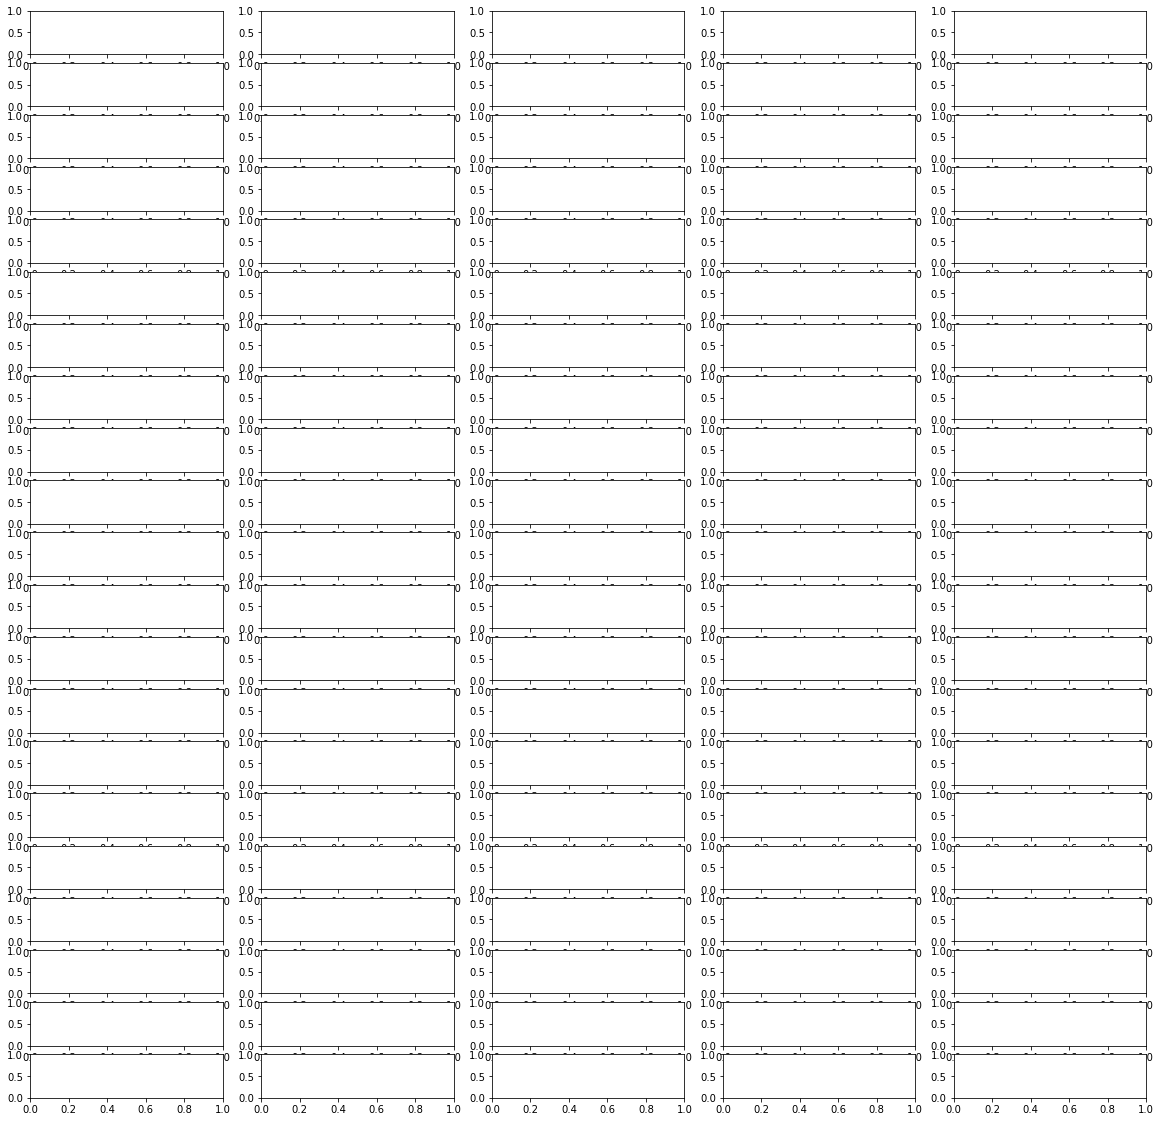

In [165]:
l_labels = np.unique(data['label'])
NB_PAR_LIGNE = 5
print(l_labels)
#idx = data['label'].index("Bear")
#print(idx)
#print(data["data"][idx== "Bear"][0])

 
idx = data['label'].index(label)
     
data['data'][idx]
data['label'][idx]


fig, axs = plt.subplots(len(l_labels), NB_LIGNE, figsize=(20, 20))
for i, d in enumerate(l_labels):
    #print(i,d)
    for j in range(NB_PAR_LIGNE):
        
        #print(j,d, data["label"].index(d)+j)
        image= data["data"][data['label'].index(d)== d]
        #axs[i,j].imshow(image) # permet d'afficher sur une même ligne 'M' image représentant le même chiffre
        #axs[i,j].axis('off')



#X = np.array(data['data'])
#y = np.array(data['label'])

106
927
415
5527
2549
5138
5628
830
2449
632
5730
5038
4938
307
515
0
732
315
2349
1086
207


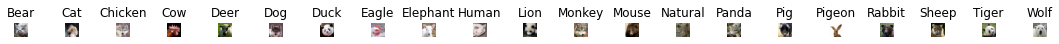

In [161]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,10)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
    print(idx) 
    ax.imshow(data['data'][idx//2])
    ax.axis('off')
    ax.set_title(label)

## 6 - Diviser vos données en un ensemble de test et un ensemble de train.  
  
**Consigne**: utilisation de la fonction train_test_split de scikit-learn (80% de l'ensemble total pour 'entraînement et le reste pour l'ensemble de test).  
  
**Remarques**: Dans l'ensemble de données, les photos sont classées par animal, nous ne pouvons donc pas simplement diviser à 80%, (si les données sont ordonnées et que nous nous divisons à une certaine position, nous nous retrouverons avec certains animaux (types) apparaissant dans un seul des deux ensembles).  
Nous pouvons résoudre ce problème en mélangeant les données avant de les fractionner. De cette façon, nous égalisons les distributions dans l'ensemble de train et de test et les rendons comparables. La fonction “train_test_split” de sklearn fournit un paramètre shuffle pour prendre en charge cela tout en effectuant le fractionnement.  
“Random_state” amorce le mélange pour qu'il soit aléatoire, mais de manière reproductible.


## 7 - Vérifier que la distribution des photos dans l'ensemble de formation et de test est similaire.  
* Examiner le nombre relatif de photos par catégorie.
* Que pensez-vous des distributions ?
* Existe-t-il un moyen de s’assurer de l’obtention de distributions égales dans l'ensemble d'apprentissage et de test ?


## 8 - Traitement des données  
Une approche classique de la reconnaissance d'objets est HOG-SVM, qui signifie Histogramme des dégradés orientés (Histogram of Oriented Gradients) et Support Vector
Machines. Les HOG sont utilisés pour la réduction des caractéristiques, en d'autres termes :  
pour réduire la complexité du problème, tout en conservant autant de variations que possible.  
Pour calculer un HOG, une image est divisée en blocs, par exemple 8 par 8 pixels. Pour chacun de ces blocs, la magnitude du gradient dans un nombre donné de directions
est calculée. Pour une explication détaillée, vous pouvez vous référer à ce tutoriel :  
* http://www.learnopencv.com/histogram-of-oriented-gradients

Par exemple sur l’image ci-dessous, si l’on réduit l’image à un tier, puis que l’on calcule le HOG, on pourra renvoyer une représentation visuelle comme celle-ci :  
    ![Image](img2.png)  
  
Le nombre de points de données à traiter dans notre modèle a été réduit à ~ 15%, et avec un peu d'imagination, nous pouvons encore reconnaître un chien dans le HOG. 
  
Lors du calcul du HOG, nous effectuons une transformation. Nous pouvons transformer l'ensemble de notre ensemble de données à l'aide de transformateurs. Les transformateurs sont des objets qui se servent dans le tableau de données, transforment chaque élément et renvoient les données résultantes.  
Ici, nous devons convertir les images couleur en niveaux de gris, calculer leurs HOG et enfin mettre à l'échelle les données. Pour cela, nous utilisons trois transformateurs à la suite:
* RGB2GrayTransformer,
* HOGTransformer
* StandardScaler.  
  
Le résultat final est un tableau avec un HOG pour chaque image de l'entrée.  
  
Scikit-learn est livré avec de nombreux transformateurs intégrés, tels qu'un StandardScaler pour mettre à l'échelle des entités et un Binarizer pour mapper des entités de chaîne à des entités numériques. De plus, il fournit les classes BaseEstimator et TransformerMixin pour faciliter la création de vos propres Transformers.  
  
 Un transformateur personnalisé peut être créé en héritant de ces deux classes (BaseEstimator, TransformerMixin) et en implémentant une méthode \__init__, fit() et transform(). La classe TransformerMixin fournit la méthode fit_transform(), qui combine l'ajustement et la transformation que nous avons implémentés.  
 
Créer vos classes RGB2GrayTransformer and HOGTransformer.  
Après avoir instancié chaque transformateur (RGB2GrayTransformer(), HogTransformer(), StandardScaler()), mettez à l’échelle votre échantillon de données en appelant fit_transform() à chaque transformation en convertissant X_train étape par étape (RGB2GrayTransformer, puis HogTransformer, puis StandardScaler).

## 9 - Entraîner un classifieur.  
Nous commencerons par Stochastic Gradient Descent (SGD), car il est rapide et fonctionne relativement bien.


## 10 - Évaluer les faux positifs grâce à une matrice de confusion.


## 11 - Mettre en place un pipeline qui pré-traite les données.  
(RGB2GrayTransformer(), HogTransformer(), StandardScaler()), entraîne le modèle et nous permet de modifier
les paramètres plus facilement.  
En utilisant un pipeline, nous pouvons optimiser à la fois les transformations et le classificateur en une seule procédure. De plus, au lieu de modifier manuellement les
paramètres, nous pouvons utiliser un GridSearchCV.


## 12 - Pour cela, définir une grille de paramètres (param_grid = [{...}]).


## 13 - Évaluer dans le même objet Grid Search, le classifieur SGD, le classifieur SVM, ainsi qu’un classifieur Naïve Bayes.  
Une fois le Grid Search terminé, le modèle sera entraîné une dernière fois, en utilisant l'ensemble complet d'apprentissage et les paramètres optimaux.
Que pouvez-vous conclure de ces modèles, en étudiant le fonctionnement intrinsèque du SVM et du Naive Bayes, est-on capable d’anticiper quel algorithme sera le
plus efficace pour cette tâche de classification d’images ?


## 14 - Évaluer les résultats des modèles (avec paramètres optimaux calculés par le Grid Search).  
Quel classifieur offre de meilleurs scores pour cette tâche ?


## 15 - Enregistrer vos résultats dans un fichier pickle (joblib).  
Afin de pouvoir recharger les résultats lorsque vous en aurez besoin (par ex avec Heroku).


# Zone Bonus :)

## 16 - Créer votre propre dataset avec des images provenant de Google Image.  
Appliquer votre pipeline sur ce nouveau jeu de données. Au besoin, relancer un Grid Search.


## 17 - Développer une interface utilisateur (Dash).  
Elle devra permettre de charger une image, puis de retourner le label de l’image (la classe).


## 18 - Quelles seraient les adaptations à faire pour offrir un logiciel de labellisation automatique ?  
Proposer un cahier des charges précis. Proposer une implémentation (une mise en œuvre). Réfléchir à la manière la plus appropriée de stocker les libellés
des images afin que ceux-ci soient indépendant de l’application sur


## 19 - Après avoir réalisé une veille sur les tests unitaires, fonctionnels, de non-régression.  
Programmer vos tests unitaires et fonctionnels.


## 20 - Finalisation:  
Afin de trouver facilement les images qui lui permettront d’appuyer ces présentations pédagogiques aux enfants de sa classe, votre ami souhaite une application similaire à
Google Image dédiée à ses images contenues sur son disque dur. Que pouvez-vous luiproposer ? Quelles sont les types d’algorithmes qui permettent de réaliser ce type
d’application ?


## 21 - Réfléchir à une solution de stockage des images.


## 22 - Programmer votre propre application Google Image !!!!